# Stability analysis of model

Now the objective is to select the best model and to ensure its validity over time.

How can we evaluate our model choice ? This is the protocol I will follow for each of the selected amounts of time in months

1. Train the best model on the first period of time __m<sup>1</sup>__
2. Train the best model on the _n<sup>th</sup>_ periods of time __m<sup>th</sup>__
3. At each iteration, compare the clustering fit from __m<sup>1</sup>__ to __m<sup>th</sup>__ using ARI score
4. Plot and decide for which period of time the model is stable

Theses are the results of the experiments :

| Clustering   | Silhouette Score | Clusters | Model   |
|--------------|------------------|----------|---------|
| KMeans       | 0.35             | 4        | RFM     |
| **CAH**      | **0.43**         | **5**    | **RFM** |
| DBSCAN       | 0.64             | 2        | RFM     |
| KMeans       | 0.30             | 6        | RFMS    |
| K-Prototypes | 0.30             | 4        | RFMS    |
| DBSCAN       | 0.61             | 2        | RFMS    |
| CAH          | 0.34             | 2        | RFMS    |
| KMeans       | 0.35             | 7        | RMS     |
| DBSCAN       | 0.76             | 2        | RMS     |
| CAH          | 0.42             | 2        | RMS     |
| CAH          | **0.83**         | 4        | RMSPPL  |
| DBSCAN       | 0.20             | 4        | RMSPPL  |
| K-Prototypes | 0.15             | 4        | RMSPPL  |
| KMeans       | 0.23             | 4        | RMSPPL  |


From the experiments done until then, the best model is CAH regarding silhouette score but have a really bad clustering performance only by using RFM.

To filter by period, we will

## 1 - Evaluating the stability of the model on monthly basis

In [46]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering

customers = pd.read_csv(
    "./../output/rfmsppl.csv", parse_dates=["first_order", "last_order"]
)

customers

,recency,frequency,monetary,nb_orders,first_order,last_order,days_between_orders,scoring_R,scoring_F,scoring_M,...,customer_zip_code_prefix,customer_city,customer_state,scoring_PR,payment_sequential,payment_installments,payment_value_boleto,payment_value_voucher,payment_value_credit_card,payment_value_debit_card
0,112.0,0.200000,141.90,1.0,2018-05-10 10:56:27,2018-05-10 10:56:27,0,4,4,4,...,7787,cajamar,SP,1,1.0,8.0,0.0,0.0,141.899994,0.0
1,115.0,0.200000,27.19,1.0,2018-05-07 11:11:27,2018-05-07 11:11:27,0,4,4,1,...,6053,osasco,SP,1,1.0,1.0,0.0,0.0,27.190001,0.0
2,537.0,0.052632,86.22,1.0,2017-03-10 21:05:03,2017-03-10 21:05:03,0,1,1,2,...,88115,sao jose,SC,1,1.0,8.0,0.0,0.0,86.220001,0.0
3,321.0,0.083333,43.62,1.0,2017-10-12 20:29:41,2017-10-12 20:29:41,0,2,2,1,...,66812,belem,PA,1,1.0,4.0,0.0,0.0,43.619999,0.0
4,288.0,0.090909,196.89,1.0,2017-11-14 19:45:42,2017-11-14 19:45:42,0,2,2,4,...,18040,sorocaba,SP,1,1.0,6.0,0.0,0.0,196.889999,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88135,245.0,0.111111,167.32,1.0,2017-12-27 22:36:41,2017-12-27 22:36:41,0,3,3,4,...,60055,fortaleza,CE,9,1.0,2.0,0.0,0.0,167.320007,0.0
88136,262.0,0.100000,84.58,1.0,2017-12-10 20:07:56,2017-12-10 20:07:56,0,3,2,2,...,44054,feira de santana,BA,9,1.0,1.0,0.0,0.0,84.580002,0.0
88137,568.0,0.050000,112.46,1.0,2017-02-07 15:49:16,2017-02-07 15:49:16,0,1,1,3,...,78552,sinop,MT,9,1.0,1.0,0.0,0.0,112.459999,0.0
88138,119.0,0.200000,133.69,1.0,2018-05-02 15:17:41,2018-05-02 15:17:41,0,4,4,4,...,29460,bom jesus do norte,ES,9,1.0,5.0,0.0,0.0,133.690002,0.0


First we need to segment the database into month pieces !

The dataset got its first order in September of 2016 and its last order in August of 2018, it's 25 months of data but data of these first month and last month are incomplete
so we will consider the period of time from October of 2016 to July of 2017.

In [47]:
min_order = customers["first_order"].min()

customers["month_group"] = 0
customers.loc[:, "months_since_first"] = (
    round((customers["first_order"] - min_order).dt.days / 30) + 1
)
customers["month_group"] = customers["months_since_first"].astype("int")

distributed_customers = customers.copy()

print(
    distributed_customers["first_order"].min(),
    distributed_customers["first_order"].max(),
)
print(sorted(distributed_customers["month_group"].unique()))

2016-10-03 16:56:50 2018-08-29 15:00:37
[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [48]:
# No orders on November 2016 ? WTF
distributed_customers[
    (distributed_customers.first_order.dt.year == 2016)
    & (distributed_customers.first_order.dt.month == 11)
]

,recency,frequency,monetary,nb_orders,first_order,last_order,days_between_orders,scoring_R,scoring_F,scoring_M,...,customer_state,scoring_PR,payment_sequential,payment_installments,payment_value_boleto,payment_value_voucher,payment_value_credit_card,payment_value_debit_card,month_group,months_since_first


In [49]:
distributed_customers

,recency,frequency,monetary,nb_orders,first_order,last_order,days_between_orders,scoring_R,scoring_F,scoring_M,...,customer_state,scoring_PR,payment_sequential,payment_installments,payment_value_boleto,payment_value_voucher,payment_value_credit_card,payment_value_debit_card,month_group,months_since_first
0,112.0,0.200000,141.90,1.0,2018-05-10 10:56:27,2018-05-10 10:56:27,0,4,4,4,...,SP,1,1.0,8.0,0.0,0.0,141.899994,0.0,20,20.0
1,115.0,0.200000,27.19,1.0,2018-05-07 11:11:27,2018-05-07 11:11:27,0,4,4,1,...,SP,1,1.0,1.0,0.0,0.0,27.190001,0.0,20,20.0
2,537.0,0.052632,86.22,1.0,2017-03-10 21:05:03,2017-03-10 21:05:03,0,1,1,2,...,SC,1,1.0,8.0,0.0,0.0,86.220001,0.0,6,6.0
3,321.0,0.083333,43.62,1.0,2017-10-12 20:29:41,2017-10-12 20:29:41,0,2,2,1,...,PA,1,1.0,4.0,0.0,0.0,43.619999,0.0,13,13.0
4,288.0,0.090909,196.89,1.0,2017-11-14 19:45:42,2017-11-14 19:45:42,0,2,2,4,...,SP,1,1.0,6.0,0.0,0.0,196.889999,0.0,15,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88135,245.0,0.111111,167.32,1.0,2017-12-27 22:36:41,2017-12-27 22:36:41,0,3,3,4,...,CE,9,1.0,2.0,0.0,0.0,167.320007,0.0,16,16.0
88136,262.0,0.100000,84.58,1.0,2017-12-10 20:07:56,2017-12-10 20:07:56,0,3,2,2,...,BA,9,1.0,1.0,0.0,0.0,84.580002,0.0,15,15.0
88137,568.0,0.050000,112.46,1.0,2017-02-07 15:49:16,2017-02-07 15:49:16,0,1,1,3,...,MT,9,1.0,1.0,0.0,0.0,112.459999,0.0,5,5.0
88138,119.0,0.200000,133.69,1.0,2018-05-02 15:17:41,2018-05-02 15:17:41,0,4,4,4,...,ES,9,1.0,5.0,0.0,0.0,133.690002,0.0,20,20.0


In [50]:
in_period = (distributed_customers.first_order >= "2016-10-01") & (
    distributed_customers.first_order <= "2018-07-31"
)

distributed_customers = distributed_customers.loc[in_period, :]

# If the Second Order is out of range, replace it with the First Order date
out_of_period = (distributed_customers.last_order <= "2016-10-01") & (
    distributed_customers.last_order >= "2018-07-31"
)
distributed_customers.loc[out_of_period, "nb_orders"] = 1
distributed_customers.loc[out_of_period, "days_between_orders"] = 0
distributed_customers.loc[out_of_period, "last_order"] = distributed_customers[
    "first_order"
]

distributed_customers

,recency,frequency,monetary,nb_orders,first_order,last_order,days_between_orders,scoring_R,scoring_F,scoring_M,...,customer_state,scoring_PR,payment_sequential,payment_installments,payment_value_boleto,payment_value_voucher,payment_value_credit_card,payment_value_debit_card,month_group,months_since_first
0,112.0,0.200000,141.90,1.0,2018-05-10 10:56:27,2018-05-10 10:56:27,0,4,4,4,...,SP,1,1.0,8.0,0.0,0.0,141.899994,0.0,20,20.0
1,115.0,0.200000,27.19,1.0,2018-05-07 11:11:27,2018-05-07 11:11:27,0,4,4,1,...,SP,1,1.0,1.0,0.0,0.0,27.190001,0.0,20,20.0
2,537.0,0.052632,86.22,1.0,2017-03-10 21:05:03,2017-03-10 21:05:03,0,1,1,2,...,SC,1,1.0,8.0,0.0,0.0,86.220001,0.0,6,6.0
3,321.0,0.083333,43.62,1.0,2017-10-12 20:29:41,2017-10-12 20:29:41,0,2,2,1,...,PA,1,1.0,4.0,0.0,0.0,43.619999,0.0,13,13.0
4,288.0,0.090909,196.89,1.0,2017-11-14 19:45:42,2017-11-14 19:45:42,0,2,2,4,...,SP,1,1.0,6.0,0.0,0.0,196.889999,0.0,15,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88135,245.0,0.111111,167.32,1.0,2017-12-27 22:36:41,2017-12-27 22:36:41,0,3,3,4,...,CE,9,1.0,2.0,0.0,0.0,167.320007,0.0,16,16.0
88136,262.0,0.100000,84.58,1.0,2017-12-10 20:07:56,2017-12-10 20:07:56,0,3,2,2,...,BA,9,1.0,1.0,0.0,0.0,84.580002,0.0,15,15.0
88137,568.0,0.050000,112.46,1.0,2017-02-07 15:49:16,2017-02-07 15:49:16,0,1,1,3,...,MT,9,1.0,1.0,0.0,0.0,112.459999,0.0,5,5.0
88138,119.0,0.200000,133.69,1.0,2018-05-02 15:17:41,2018-05-02 15:17:41,0,4,4,4,...,ES,9,1.0,5.0,0.0,0.0,133.690002,0.0,20,20.0


In [51]:
selected_variables = ["recency", "frequency", "monetary", "review_score"]

selected_variables.append("month_group")
distributed_customers = distributed_customers[selected_variables]

distributed_customers

,recency,frequency,monetary,review_score,month_group
0,112.0,0.200000,141.90,5.0,20
1,115.0,0.200000,27.19,4.0,20
2,537.0,0.052632,86.22,3.0,6
3,321.0,0.083333,43.62,4.0,13
4,288.0,0.090909,196.89,5.0,15
...,...,...,...,...,...
88135,245.0,0.111111,167.32,5.0,16
88136,262.0,0.100000,84.58,4.0,15
88137,568.0,0.050000,112.46,5.0,5
88138,119.0,0.200000,133.69,5.0,20


In [52]:
distributed_customers.groupby("month_group").count()

,recency,frequency,monetary,review_score
month_group,,,,
1,229,229,229,229
4,97,97,97,97
5,1554,1554,1554,1554
6,1779,1779,1779,1779
7,2140,2140,2140,2140
8,2591,2591,2591,2591
9,3166,3166,3166,3166
10,2798,2798,2798,2798
11,3624,3624,3624,3624


We need at least 20 000 customers to get a performant model so we will use the 13 first groups as basis for the model m<sup>1</sup>.

* To build m<sup>2</sup>, we will use the 14 first groups
* To build m<sup>3</sup>, we will use the 15 first groups
* etc ...

| Model          | Groups used  | Group Month of comparison for ARI |
|----------------|--------------|-----------------------------------|
| m<sup>1</sup>  | from 1 to 13 | _Not applicable_                  |
| m<sup>2</sup>  | from 1 to 14 | 14                                |
| m<sup>3</sup>  | from 1 to 15 | 15                                |
| m<sup>4</sup>  | from 1 to 16 | 16                                |
| m<sup>5</sup>  | from 1 to 17 | 17                                |
| m<sup>6</sup>  | from 1 to 18 | 18                                |
| m<sup>7</sup>  | from 1 to 19 | 19                                |
| m<sup>8</sup>  | from 1 to 20 | 20                                |
| m<sup>9</sup>  | from 1 to 21 | 21                                |
| m<sup>10</sup> | from 1 to 22 | 22                                |
| m<sup>11</sup> | from 1 to 23 | 23                                |
| m<sup>12</sup> | from 1 to 24 | 24                                |


## Preparation of the Dataset for training

In [53]:
def prepare_data_for_model(customers: pd.DataFrame):
    scaler = StandardScaler()

    return scaler.fit_transform(customers)


def get_trained_model(month_group, verbose=False):
    customers = distributed_customers.query("month_group <= @month_group")

    if verbose:
        print(
            "Trained on {0} Customers until Group Month {1}".format(
                str(customers.shape[0]), str(month_group)
            )
        )

    scaled_customers = prepare_data_for_model(customers)

    return AgglomerativeClustering(
        n_clusters=5, linkage="ward", affinity="euclidean", compute_full_tree=False
    ).fit(scaled_customers)


def predict_group_labels(trained_model, month_group, model_name, verbose=False):
    customers = distributed_customers.query("month_group <= @month_group")

    if verbose:
        print(
            "Predict {0} Customers Labels for original group By {1}".format(
                str(customers.shape[0]), model_name
            )
        )

    model_labels = trained_model.labels_

    return model_labels[: customers.shape[0]]

In [54]:
def get_ari_graph(months_of_training, verbose=False):

    print(
        "Number of Customers used to train the Basis model: {0}".format(
            str(
                distributed_customers.query("month_group <= @months_of_training").shape[
                    0
                ]
            )
        )
    )
    m1 = get_trained_model(months_of_training)
    true_labels = m1.labels_

    ari_scores = []

    for model in range(2, (25 - (months_of_training - 2))):
        group_month = model + (months_of_training - 1)
        # Train the model with the new data
        new_model = get_trained_model(group_month, verbose)

        # Get the predicted labels predicted by the new model
        predicted_labels = predict_group_labels(
            new_model, months_of_training, f"Model {group_month}", verbose
        )

        ari_scores.append(
            {
                "month": model - 1,
                "ari_score": adjusted_rand_score(true_labels, predicted_labels),
            }
        )

    pd.DataFrame(ari_scores).plot(
        title="Evolution of ARI Score per Month", x="month", y="ari_score"
    );

Trained on 29392 Customers until Group Month 14
Predict 25559 Customers Labels for original group By Model 14
Trained on 37108 Customers until Group Month 15
Predict 25559 Customers Labels for original group By Model 15
Trained on 41539 Customers until Group Month 16
Predict 25559 Customers Labels for original group By Model 16
Trained on 48069 Customers until Group Month 17
Predict 25559 Customers Labels for original group By Model 17
Trained on 54464 Customers until Group Month 18
Predict 25559 Customers Labels for original group By Model 18
Trained on 60814 Customers until Group Month 19
Predict 25559 Customers Labels for original group By Model 19
Trained on 67439 Customers until Group Month 20
Predict 25559 Customers Labels for original group By Model 20
Trained on 72848 Customers until Group Month 21
Predict 25559 Customers Labels for original group By Model 21
Trained on 78006 Customers until Group Month 22
Predict 25559 Customers Labels for original group By Model 22
Trained on

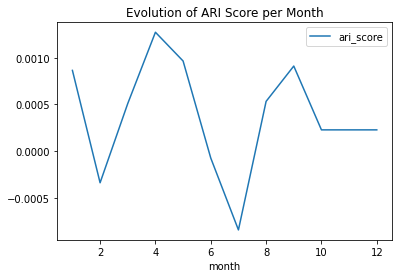

Number of Customers used to train the Basis model: 25559
Trained on 29392 Customers until Group Month 14
Predict 25559 Customers Labels for original group By Model 14
Trained on 37108 Customers until Group Month 15
Predict 25559 Customers Labels for original group By Model 15
Trained on 41539 Customers until Group Month 16
Predict 25559 Customers Labels for original group By Model 16
Trained on 48069 Customers until Group Month 17
Predict 25559 Customers Labels for original group By Model 17
Trained on 54464 Customers until Group Month 18
Predict 25559 Customers Labels for original group By Model 18
Trained on 60814 Customers until Group Month 19
Predict 25559 Customers Labels for original group By Model 19
Trained on 67439 Customers until Group Month 20
Predict 25559 Customers Labels for original group By Model 20
Trained on 72848 Customers until Group Month 21
Predict 25559 Customers Labels for original group By Model 21
Trained on 78006 Customers until Group Month 22
Predict 25559 C

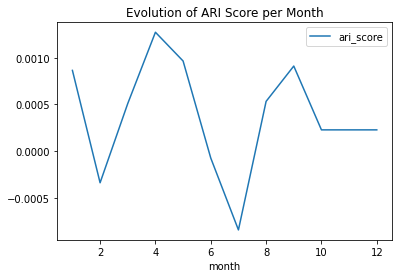

In [55]:
# Create the DataFrame of ARI Scores (~25k of Customers)

get_ari_graph(13, verbose=True)

The evolution of ARI Score show that the performance decrease a lot after 6 months, but we had only 20k customers : what if we collect more customers ?